In [ ]:
!pip install -r requirements.txt


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


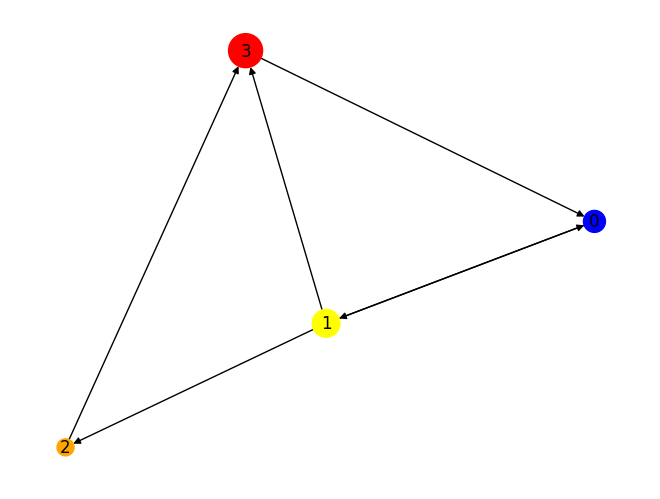

In [ ]:
import networkx as nx
H = nx.DiGraph()

#adding nodes
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),

  (1, {"color": "yellow", "size": 400}),

  (2, {"color": "orange", "size": 150}),

  (3, {"color": "red", "size": 600})


])

#adding edges
H.add_edges_from([
  (0, 1),

  (1, 2),

  (1, 0),

  (1, 3),

  (2, 3),

  (3,0)


])

node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

#Plotting Graph
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

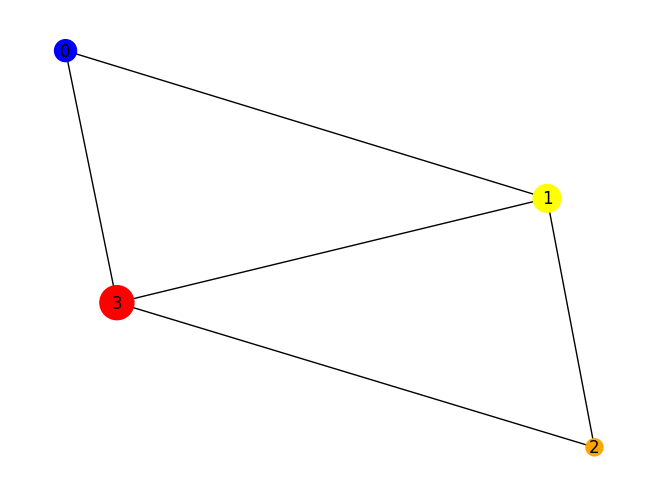

In [ ]:
#converting to undirected graph
G = H.to_undirected()
nx.draw(G, with_labels=True, node_color=colors, node_size=sizes)

In [ ]:
!pip install -q torch

In [ ]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)



GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

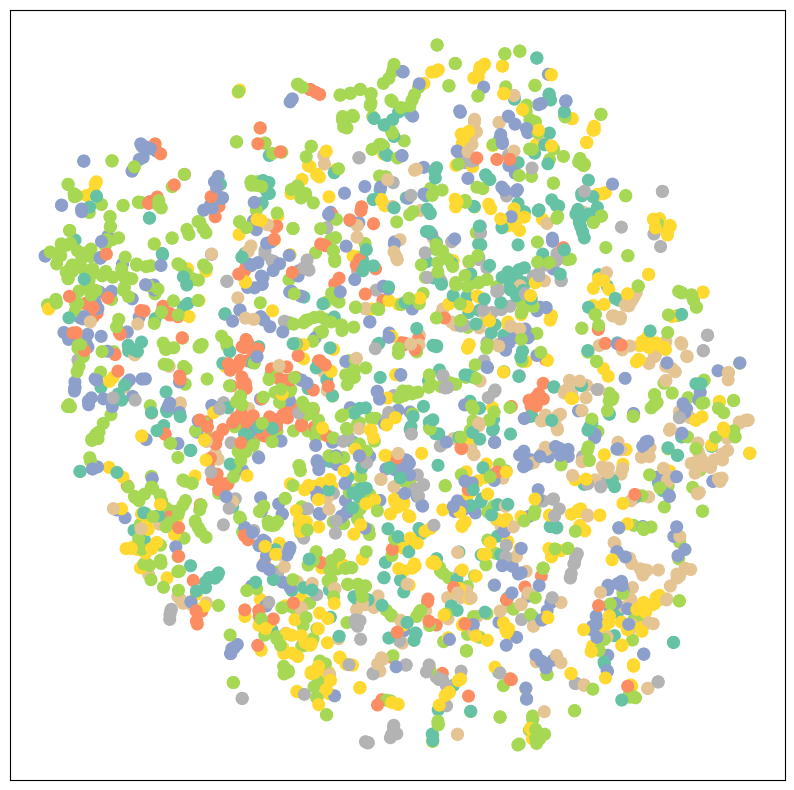

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.8150


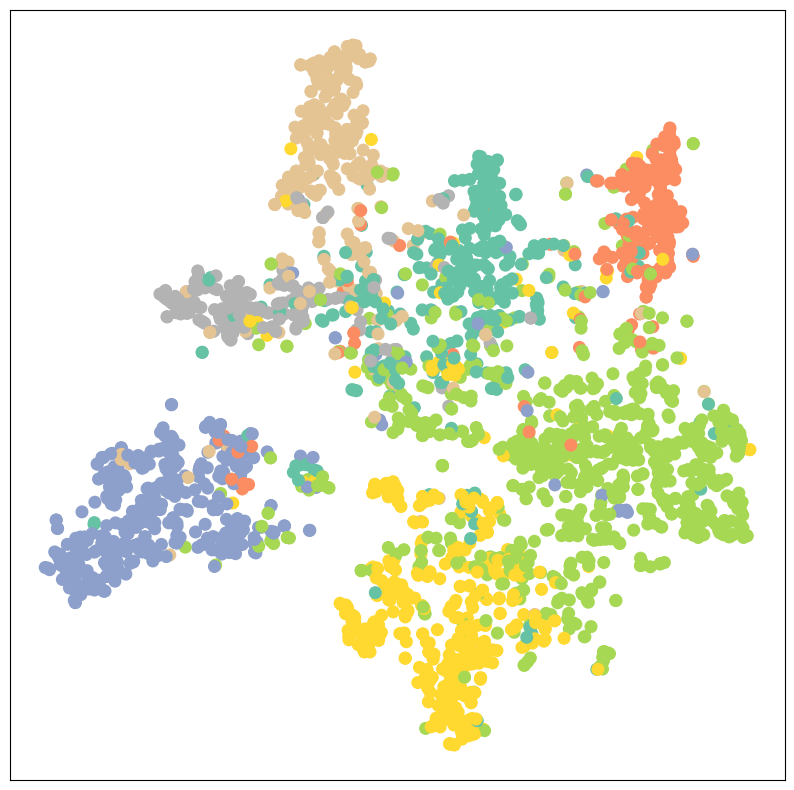

In [ ]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')



GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.3520, Test: 0.3770
Epoch: 002, Loss: 3.9926, Val: 0.4760, Test: 0.5240
Epoch: 003, Loss: 3.9555, Val: 0.5000, Test: 0.5560
Epoch: 004, Loss: 3.9104, Val: 0.5440, Test: 0.5740
Epoch: 005, Loss: 3.8645, Val: 0.5500, Test: 0.5870
Epoch: 006, Loss: 3.8111, Val: 0.5560, Test: 0.5800
Epoch: 007, Loss: 3.7478, Val: 0.5460, Test: 0.5730
Epoch: 008, Loss: 3.6821, Val: 0.5320, Test: 0.5650
Epoch: 009, Loss: 3.6151, Val: 0.5280, Test: 0.5610
Epoch: 010, Loss: 3.5253, Val: 0.5220, Test: 0.5570
Epoch: 011, Loss: 3.4305, Val: 0.5080, Test: 0.5490
Epoch: 012, Loss: 3.3468, Val: 0.5040, Test: 0.5430
Epoch: 013, Loss: 3.2313, Val: 0.4900, Test: 0.5280
Epoch: 014, Loss: 3.1400, Val: 0.4800, Test: 0.5180
Epoch: 015, Loss: 3.0162, Val: 0.4700, Test: 0.5080
Epoch: 016, Loss: 2.9145, Val: 0.4620, Test: 0.4990
Epoch: 017, Loss: 2.7860, Val: 0.4520, Test: 0.4940
Epoch: 018, Loss: 2.6948, Val: 0.4340

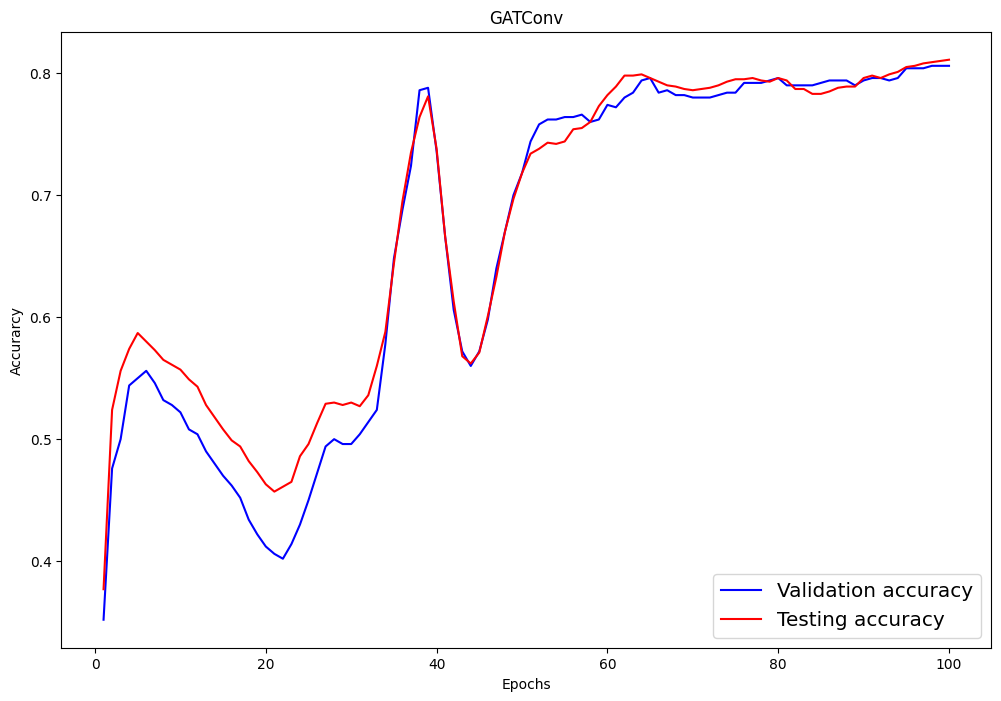

In [ ]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

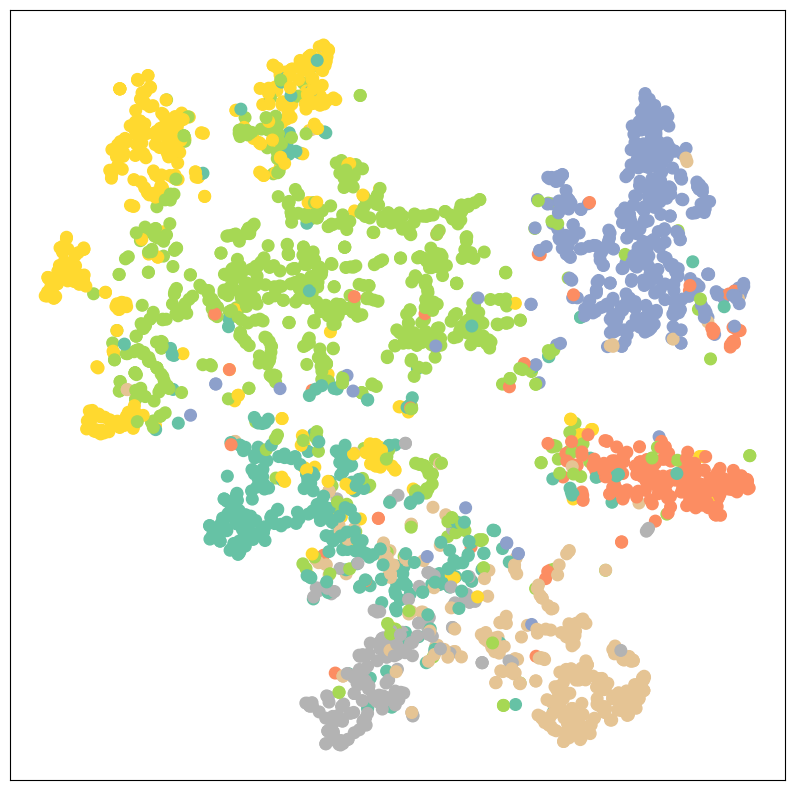

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

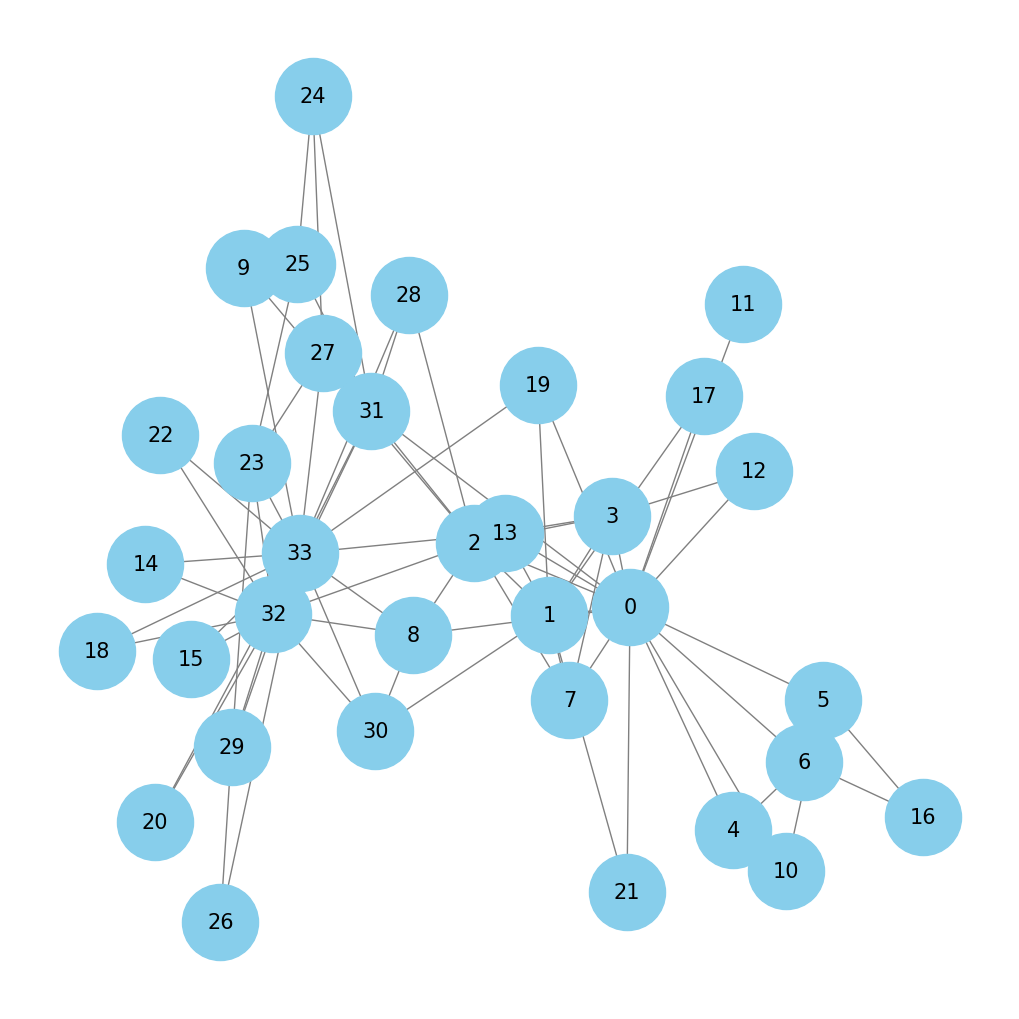

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Load graph data
G = nx.karate_club_graph()

# Visualize the graph
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=3000, font_size=15)
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Example: Node features as degree
features = np.array([d for n, d in G.degree()])
features = features.reshape(-1, 1)

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Replace these with your actual data
features = [[1, 2], [2, 3], [3, 4], [4, 5]]  # Example features
labels = [0, 1, 0, 1]  # Example labels

# Example edges (replace with your actual edge list)
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]

# Prepare data
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

# Make sure data.y is properly assigned
data = Data(x=x, edge_index=edge_index, y=y)

# Model, optimizer, and loss function
model = GCN(in_channels=x.size(1), hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 1.2263996601104736
Epoch 10, Loss: 0.7735956907272339
Epoch 20, Loss: 0.7120850086212158
Epoch 30, Loss: 0.6939135193824768
Epoch 40, Loss: 0.693701982498169
Epoch 50, Loss: 0.694021463394165
Epoch 60, Loss: 0.6937134861946106
Epoch 70, Loss: 0.6934632062911987
Epoch 80, Loss: 0.6933436393737793
Epoch 90, Loss: 0.6932902336120605
Epoch 100, Loss: 0.69326251745224
Epoch 110, Loss: 0.6932445168495178
Epoch 120, Loss: 0.6932307481765747
Epoch 130, Loss: 0.6932191252708435
Epoch 140, Loss: 0.6932090520858765
Epoch 150, Loss: 0.6932001113891602
Epoch 160, Loss: 0.6931922435760498
Epoch 170, Loss: 0.6931852102279663
Epoch 180, Loss: 0.6931790709495544
Epoch 190, Loss: 0.6931737661361694


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import numpy as np

# Create a sample graph
G = nx.karate_club_graph()

# Example node features (degree of each node)
features = np.array([d for n, d in G.degree()]).reshape(-1, 1)
features = torch.tensor(features, dtype=torch.float)

# Example target labels (club membership in the Karate Club graph)
# Here we create a simple binary classification problem
target = [0 if G.nodes[n]['club'] == 'Mr. Hi' else 1 for n in G.nodes()]
target = torch.tensor(target, dtype=torch.long)

# Prepare edge index tensor
edge_index = torch.tensor(list(G.edges)).t().contiguous()

# Create data object
data = Data(x=features, edge_index=edge_index, y=target)

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Model, optimizer, and loss function
model = GCN(in_channels=1, hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)  # Ensure data.y is not None
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Model evaluation
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    accuracy = (pred == data.y).sum().item() / len(data.y)
    print(f'Accuracy: {accuracy}')


Epoch 0, Loss: 0.8981717228889465
Epoch 10, Loss: 0.5770247578620911
Epoch 20, Loss: 0.5282027125358582
Epoch 30, Loss: 0.47777584195137024
Epoch 40, Loss: 0.4287358224391937
Epoch 50, Loss: 0.3815886676311493
Epoch 60, Loss: 0.33864161372184753
Epoch 70, Loss: 0.29871416091918945
Epoch 80, Loss: 0.2631444036960602
Epoch 90, Loss: 0.23298601806163788
Epoch 100, Loss: 0.20899967849254608
Epoch 110, Loss: 0.19028235971927643
Epoch 120, Loss: 0.17617905139923096
Epoch 130, Loss: 0.16509564220905304
Epoch 140, Loss: 0.15617278218269348
Epoch 150, Loss: 0.14894689619541168
Epoch 160, Loss: 0.1430726796388626
Epoch 170, Loss: 0.13841384649276733
Epoch 180, Loss: 0.13463571667671204
Epoch 190, Loss: 0.1315091848373413
Accuracy: 0.9411764705882353


In [ ]:
!pip install qiskit-aer


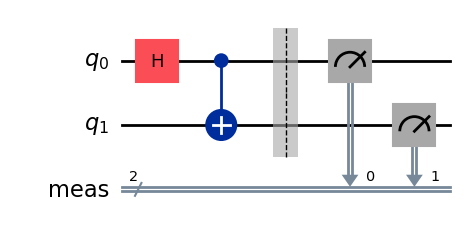

In [ ]:
!pip install pylatexenc

from qiskit import QuantumCircuit

def create_quantum_circuit():
    qc = QuantumCircuit(2)
    qc.h(0)  # Apply Hadamard gate to qubit 0
    qc.cx(0, 1)  # Apply CNOT gate
    qc.measure_all()
    return qc

qc = create_quantum_circuit()
qc.draw(output='mpl') # Now this should work

In [ ]:
!pip install --upgrade --force-reinstall pylatexenc


  Using cached pylatexenc-2.10-py3-none-any.whl
  Attempting uninstall: pylatexenc
    Found existing installation: pylatexenc 2.10
    Uninstalling pylatexenc-2.10:
      Successfully uninstalled pylatexenc-2.10


In [ ]:
qc.draw(output='text')


┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

In [ ]:
!pip install qiskit-aer


In [ ]:
!pip install tensorflow
!pip install torch torchvision torchaudio
!pip install qiskit
!pip install torch-geometric
!pip install qiskit-machine-learning


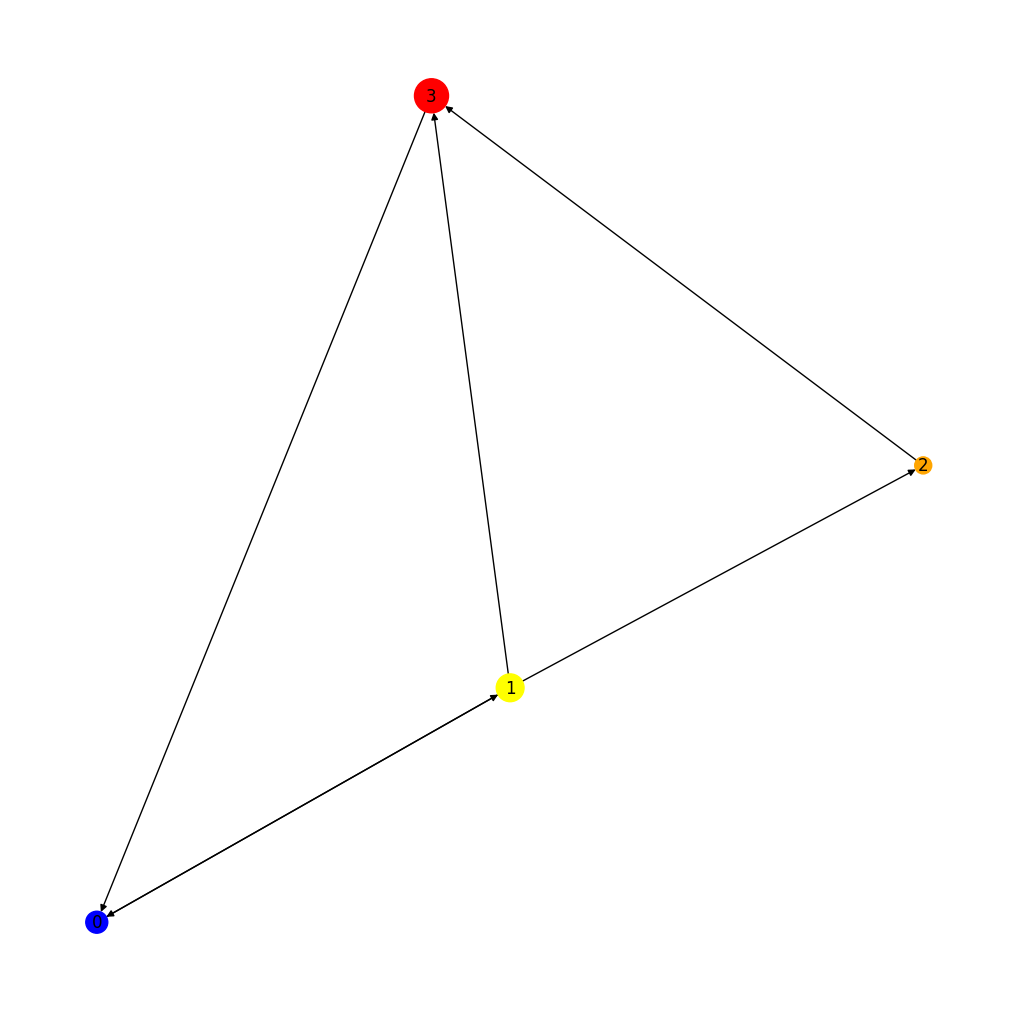

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
H = nx.DiGraph()

# Adding nodes with attributes
H.add_nodes_from([
    (0, {"color": "blue", "size": 250}),
    (1, {"color": "yellow", "size": 400}),
    (2, {"color": "orange", "size": 150}),
    (3, {"color": "red", "size": 600})
])

# Adding edges
H.add_edges_from([
    (0, 1),
    (1, 2),
    (1, 0),
    (1, 3),
    (2, 3),
    (3, 0)
])

# Extract node attributes for visualization
node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

# Plotting the graph
plt.figure(figsize=(10, 10))
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np

# Convert node features to tensor (using 'size' as the feature)
features = np.array([H.nodes[n]['size'] for n in H.nodes()]).reshape(-1, 1)
features = torch.tensor(features, dtype=torch.float)

# Create dummy target labels (adjust as needed)
target = torch.tensor([0, 1, 0, 1], dtype=torch.long)

# Convert edges to edge_index tensor
edge_index = torch.tensor(list(H.edges)).t().contiguous()

# Create data object for PyTorch Geometric
data = Data(x=features, edge_index=edge_index, y=target)


In [ ]:
# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Model, optimizer, and loss function
model = GCN(in_channels=1, hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Model evaluation
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    accuracy = (pred == data.y).sum().item() / len(data.y)
    print(f'Accuracy: {accuracy}')


Epoch 0, Loss: 43.85305404663086
Epoch 10, Loss: 8.043956756591797
Epoch 20, Loss: 4.460745811462402
Epoch 30, Loss: 1.6952972412109375
Epoch 40, Loss: 1.5246986150741577
Epoch 50, Loss: 1.0332858562469482
Epoch 60, Loss: 0.7420316934585571
Epoch 70, Loss: 0.7290557026863098
Epoch 80, Loss: 0.6930984854698181
Epoch 90, Loss: 0.6926102042198181
Epoch 100, Loss: 0.6924246549606323
Epoch 110, Loss: 0.6924585103988647
Epoch 120, Loss: 0.6926125288009644
Epoch 130, Loss: 0.6923958659172058
Epoch 140, Loss: 0.6923359632492065
Epoch 150, Loss: 0.692305326461792
Epoch 160, Loss: 0.6922867298126221
Epoch 170, Loss: 0.6922636032104492
Epoch 180, Loss: 0.6922410130500793
Epoch 190, Loss: 0.6922217607498169
Accuracy: 0.75


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=heads)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Model, optimizer, and loss function
model = GAT(in_channels=1, hidden_channels=8, out_channels=2, heads=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Model evaluation
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    accuracy = (pred == data.y).sum().item() / len(data.y)
    print(f'Accuracy: {accuracy}')


Epoch 0, Loss: 89.35855102539062
Epoch 10, Loss: 1.1850979328155518
Epoch 20, Loss: 1.0509239435195923
Epoch 30, Loss: 0.9801160097122192
Epoch 40, Loss: 0.9351368546485901
Epoch 50, Loss: 1.0691816806793213
Epoch 60, Loss: 1.1707311868667603
Epoch 70, Loss: 1.1776933670043945
Epoch 80, Loss: 1.0686875581741333
Epoch 90, Loss: 0.6823374032974243
Epoch 100, Loss: 0.6912230253219604
Epoch 110, Loss: 0.5339083075523376
Epoch 120, Loss: 0.44382816553115845
Epoch 130, Loss: 0.39298486709594727
Epoch 140, Loss: 0.3695947825908661
Epoch 150, Loss: 0.35919392108917236
Epoch 160, Loss: 0.35509011149406433
Epoch 170, Loss: 0.3528342843055725
Epoch 180, Loss: 0.3515675961971283
Epoch 190, Loss: 0.3507208526134491
Accuracy: 0.75


In [ ]:
# Define a function to train the model with given hyperparameters
def train_gcn(in_channels, hidden_channels, out_channels, lr, epochs):
    model = GCN(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Evaluate model
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        accuracy = (pred == data.y).sum().item() / len(data.y)
        print(f'Accuracy: {accuracy}')
    return accuracy

# Experiment with different hyperparameters
accuracies = []
for lr in [0.01, 0.001]:
    for hidden_channels in [16, 32]:
        accuracy = train_gcn(in_channels=1, hidden_channels=hidden_channels, out_channels=2, lr=lr, epochs=200)
        accuracies.append((lr, hidden_channels, accuracy))
        print(f'LR: {lr}, Hidden Channels: {hidden_channels}, Accuracy: {accuracy}')


Epoch 0, Loss: 113.66940307617188
Epoch 10, Loss: 10.409364700317383
Epoch 20, Loss: 8.223512649536133
Epoch 30, Loss: 4.099127292633057
Epoch 40, Loss: 4.3402276039123535
Epoch 50, Loss: 1.98514986038208
Epoch 60, Loss: 0.6996004581451416
Epoch 70, Loss: 0.8482036590576172
Epoch 80, Loss: 0.720980703830719
Epoch 90, Loss: 0.7245654463768005
Epoch 100, Loss: 0.704769492149353
Epoch 110, Loss: 0.6955299377441406
Epoch 120, Loss: 0.6920082569122314
Epoch 130, Loss: 0.6919939517974854
Epoch 140, Loss: 0.6919315457344055
Epoch 150, Loss: 0.6917558312416077
Epoch 160, Loss: 0.6917272806167603
Epoch 170, Loss: 0.6917177438735962
Epoch 180, Loss: 0.6916979551315308
Epoch 190, Loss: 0.6916830539703369
Accuracy: 0.75
LR: 0.01, Hidden Channels: 16, Accuracy: 0.75
Epoch 0, Loss: 59.36131286621094
Epoch 10, Loss: 3.580838441848755
Epoch 20, Loss: 9.64937686920166
Epoch 30, Loss: 3.159609317779541
Epoch 40, Loss: 1.398269534111023
Epoch 50, Loss: 1.335920810699463
Epoch 60, Loss: 0.9493070244789124

In [ ]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train and evaluate GraphSAGE
model = GraphSAGE(in_channels=1, hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    accuracy = (pred == data.y).sum().item() / len(data.y)
    print(f'Accuracy: {accuracy}')


Epoch 0, Loss: 138.1798553466797
Epoch 10, Loss: 1.1473634003777988e-05
Epoch 20, Loss: 0.0
Epoch 30, Loss: 0.0
Epoch 40, Loss: 0.0
Epoch 50, Loss: 0.0
Epoch 60, Loss: 0.0
Epoch 70, Loss: 0.0
Epoch 80, Loss: 0.0
Epoch 90, Loss: 0.0
Epoch 100, Loss: 0.0
Epoch 110, Loss: 0.0
Epoch 120, Loss: 0.0
Epoch 130, Loss: 0.0
Epoch 140, Loss: 0.0
Epoch 150, Loss: 0.0
Epoch 160, Loss: 0.0
Epoch 170, Loss: 0.0
Epoch 180, Loss: 0.0
Epoch 190, Loss: 0.0
Accuracy: 1.0
